In [1]:
import os,sys,inspect
 
os.chdir('../')

from detector.detector import *
from preprocessing.deconvolution import *
from simulator.utils import *
import numpy as np
import matplotlib.pyplot as plt
from images import *
import imageio
from PIL import Image
from simulator.utils import *
from ipywidgets import interactive, interact
import ipywidgets as widgets

Richardson-Lucy Deconvolution Versus Wiener Deconvolution
=====================================================
In this notebook we implement the Richardson-Lucy Deconvolution and the Wiener Deconvolution. We perform a comparison between the two algorithms to see which one is more suitable for deconvolving simulated atoms florescent images

In [2]:
"""
tasks:
1. implement richardson lucy algorithm, test it on blurred images
2. test it on atom images
3. implement wiener filtering
3. test it on atom and some blurred images
5. evaluate which one is better for photon shot noise """

'\ntasks:\n1. implement richardson lucy algorithm, test it on blurred images\n2. test it on atom images\n3. implement wiener filtering\n3. test it on atom and some blurred images\n5. evaluate which one is better for photon shot noise '

1) convolution test
------------------
We will show that the convolution of delta functions with gaussians are gaussians at these points. So if we apply deconvolution to the gaussian shaped atom signals, we should expect to obtain dots.

In [3]:
from scipy.signal import convolve2d
img_size = 100

def original_img(img_size, x0, y0):
    img = np.zeros((img_size, img_size))
    for i in range(len(x0)):
        x = int(x0[i])
        y = int(y0[i])
        img[x, y] = 1
    return img



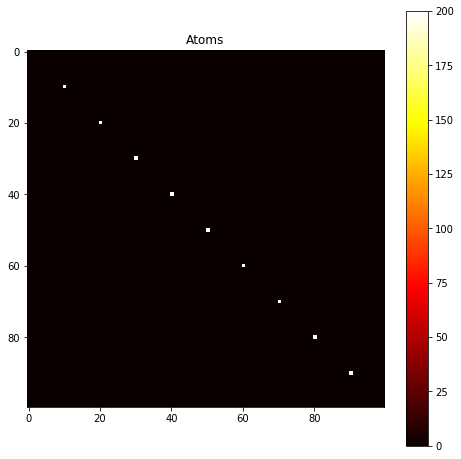

In [103]:
x0 = np.linspace(10, 90, 9)
y0 = np.linspace(10, 90, 9)
# x0 = x0[4:5]
# y0 = y0[4:5]
img = original_img(100, x0, y0)* 200

plt.figure(figsize=(8,8))
plt.title("Atoms")
plt.imshow(img, cmap='hot')
plt.colorbar()
plt.show()

[[1800.+0.j -200.+0.j -200.+0.j ... -200.+0.j -200.+0.j -200.+0.j]
 [-200.+0.j -200.+0.j -200.+0.j ... -200.+0.j -200.+0.j 1800.+0.j]
 [-200.+0.j -200.+0.j -200.+0.j ... -200.+0.j 1800.+0.j -200.+0.j]
 ...
 [-200.+0.j -200.+0.j -200.+0.j ... -200.+0.j -200.+0.j -200.+0.j]
 [-200.+0.j -200.+0.j 1800.+0.j ... -200.+0.j -200.+0.j -200.+0.j]
 [-200.+0.j 1800.+0.j -200.+0.j ... -200.+0.j -200.+0.j -200.+0.j]]


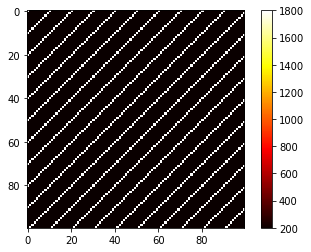

In [104]:
# should be a uniform distribution
img_fourier = np.fft.fft2(img)
plt.imshow(np.abs(img_fourier), cmap='hot')
plt.colorbar()
print(img_fourier)

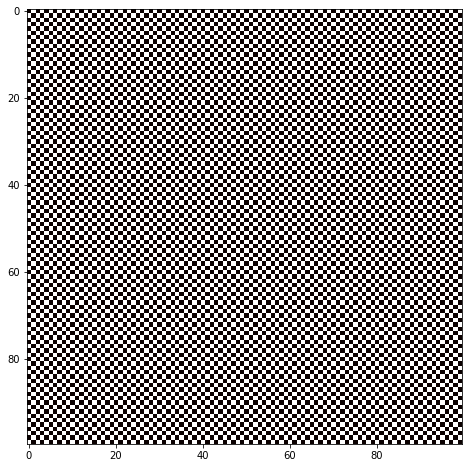

In [6]:
phase_distribution = np.angle(img_fourier)
plt.figure(figsize=(8,8))
plt.imshow(phase_distribution, cmap='hot')

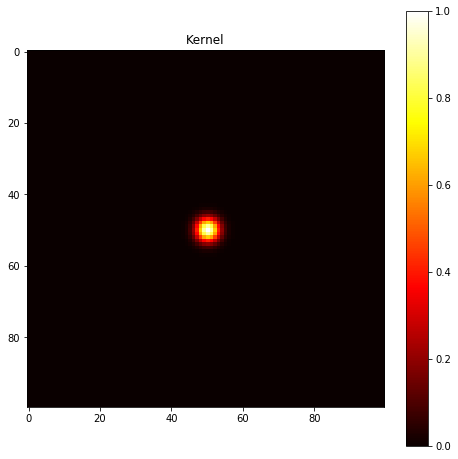

In [105]:
# kernel = np.zeros((img_size, img_size))
x = y = np.linspace(0, img_size-1, img_size)
xgrid, ygrid = np.meshgrid(x, y)  
kernel = gaussian(xgrid, ygrid, img_size//2, img_size//2, simulator.variance)

plt.figure(figsize=(8,8))
plt.title("Kernel")
plt.imshow(kernel, cmap='hot')
plt.colorbar()
plt.show()

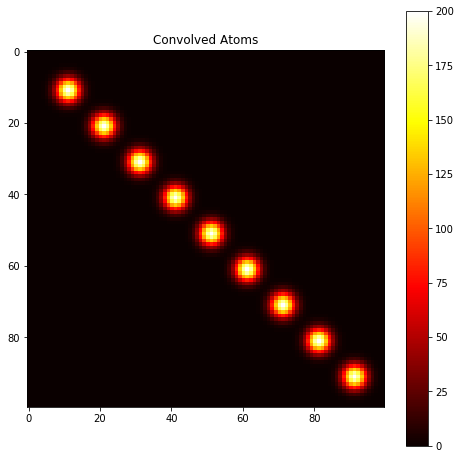

In [106]:
convolved_img = convolve2d(img, kernel, mode='same')

plt.figure(figsize=(8,8))
plt.title("Convolved Atoms")
plt.imshow(convolved_img, cmap='hot')
plt.colorbar()
plt.show()

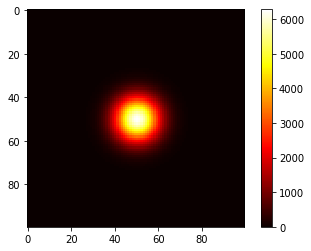

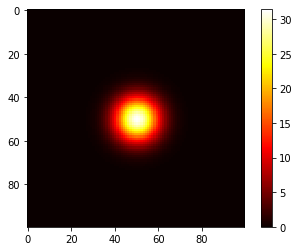

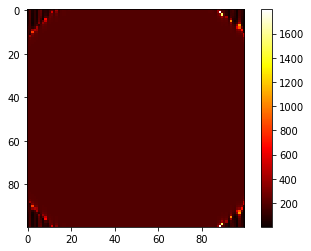

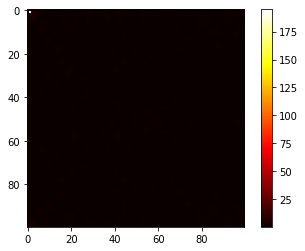

In [9]:
# deconvolution
convolved_img_fourier = np.fft.fft2(convolved_img)
plt.imshow(np.abs(np.fft.fftshift(convolved_img_fourier)), cmap='hot')
plt.colorbar()
plt.show()
kernel_fourier = np.fft.fft2(kernel)
# plt.subplot(1, 3, 2)
plt.imshow(np.abs(np.fft.fftshift(kernel_fourier)), cmap='hot')
plt.colorbar()
plt.show()

bb = np.fft.fftshift(convolved_img_fourier) / np.fft.fftshift(kernel_fourier)
# should be a constant, but it is not, why? 
plt.imshow(np.abs(bb), cmap='hot')
plt.colorbar()


plt.show()

img1 = np.fft.ifft2(np.fft.ifftshift(bb))
# a = np.fft.ifft2(convolved_img_fourier / kernel_fourier)
plt.imshow(np.abs(img1), cmap='hot')
plt.colorbar()


plt.show()

In [10]:
print(convolved_img_fourier[0, 0])
print(kernel_fourier[0, 0])

(6283.185307179586+0j)
(31.41592653589793+0j)


In [11]:
a = convolved_img_fourier[0, 0]
b = kernel_fourier[0, 0]
np.abs(a / b)

199.99999999999997

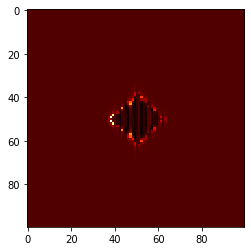

In [12]:
A = np.abs(convolved_img_fourier / kernel_fourier)
A[50, 50]
plt.imshow(A, cmap='hot')

2) Inverse Filtering
------------------------
An image can be modeled by
$$g_2 = g_1 * h + n$$
Where $g_1$ is the object, $h$ is the point spread function, ad $n$ is the shot noise. 
Applying a Fourier transform to both sides, 
$$G_2 = G_1 \cdot H + N$$
Where $H$ is now called the optical transfer function.
We can estimate $H$ by a Gaussian, then, to obtain $g_1$, we calculate
$$G_1 + \frac{N}{H} = \frac{G_2}{H}$$
applying an inverse Fourier transform, we should obtain a crude estimate of $g_1$ (it is actually $g_1 + F[\frac{N}{H}]$) we are getting back.

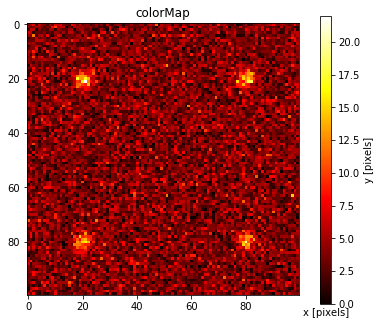

Instance info:
img_size: 100
exposure_time: 1
atom_variance: 5
quantum_efficiency: 1
atom count: 4
photons_in_background is set to 1 by default
SNR: 10
x0: [20 20 80 80]
y0: [80 20 80 20]


In [13]:
img_size = 100
SNR = 10
sim = simulator(img_size, 1)
x0 = np.array([20, 20, 80, 80])
y0 = np.array([80, 20, 80, 20])
# x0 = x0[0]
# y0 = y0[0]
g2 = sim.create_simulation_from_SNR(x0, y0, SNR, verbose=True)

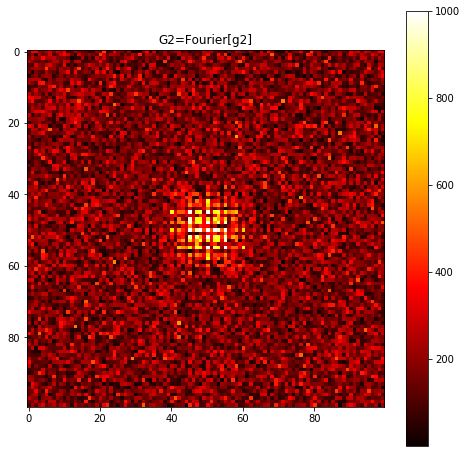

In [14]:
G2 = np.fft.fftshift(np.fft.fft2(g2))
height, width = G2.shape
# G2[height//2, width//2] = 0
plt.figure(figsize=(8,8))
plt.title("G2=Fourier[g2]")
plt.imshow(np.abs(G2), cmap='hot', vmax=1000)
plt.colorbar()
plt.show()

In [15]:
# sss = np.fft.ifft2(G2)
# plt.imshow(np.abs(sss), cmap='hot')

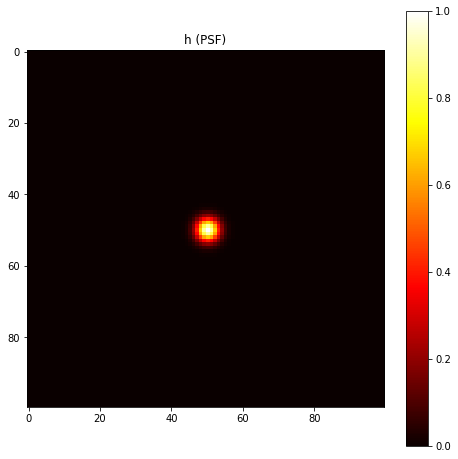

In [16]:
x = y = np.linspace(0, img_size-1, img_size)
xgrid, ygrid = np.meshgrid(x, y)  
h = gaussian(xgrid, ygrid, img_size//2, img_size//2, simulator.variance)

plt.figure(figsize=(8,8))
plt.title("h (PSF)")
plt.imshow(h, cmap='hot')
plt.colorbar()
plt.show()

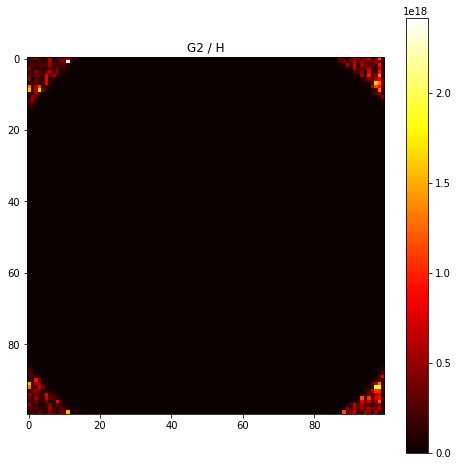

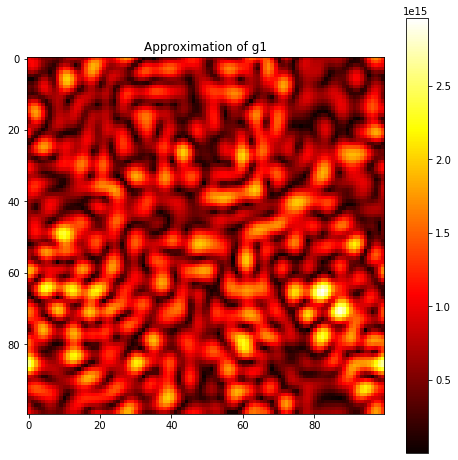

In [17]:

H = np.fft.fftshift(np.fft.fft2(h))
plt.figure(figsize=(8,8))
plt.title("G2 / H")
plt.imshow(np.abs(G2 / H), cmap='hot')
plt.colorbar()
plt.show()
g1_approx = np.fft.ifft2(np.fft.ifftshift(G2 / H))
plt.figure(figsize=(8,8))
plt.title("Approximation of g1")
plt.imshow(np.abs(g1_approx), cmap='hot')
plt.colorbar()
plt.show()


3) Low pass filtering before deconvolution
---------------------
It can be seen in section 2 that the inverse filter works horribly. This is because noise is typically of high frequency, but the OPT goes down to basically 0 at high frequencies. This causes the noise to dominate the deconvoluted image. One way of fixing this is to apply a low pass filter before doing deconvolution.


In [18]:
def make_circ_mask(img_shape, radii):
    h, w = img_shape
    Y, X = np.ogrid[:h, :w]
    center = (int(w / 2), int(h / 2))
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)

    mask = dist_from_center <= radii
    mask = np.where(mask, 1., 0.)
    return mask


# trying filtering after doing the division
def filter_image(img_fourier, radii):
    mask = make_circ_mask(img_fourier.shape, radii)
    plt.figure(figsize=(15,15))
    plt.subplots_adjust(wspace=0.5)

    plt.subplot(241)
    plt.title(f"Low Pass Filter in Fourier Space\n(radii={radii})")
    plt.imshow(mask, cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    # plt.subplot(242)
    # plt.title("Filtered Image in Fourier Space")
    # filtered_img_fourier = mask * img_fourier
    # plt.imshow(np.abs(filtered_img_fourier), cmap='hot', vmax=1000)
    # plt.colorbar(fraction=0.045, pad=0.04)

    plt.subplot(242)
    deconvolved_img_fourier = img_fourier/H
    plt.title("Deconvolved Image before Filtering")
    plt.imshow(np.abs(deconvolved_img_fourier), cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    filtered_deconvolved_img_fourier = mask * deconvolved_img_fourier
    height, width = filtered_deconvolved_img_fourier.shape
    # filtered_deconvolved_img_fourier[height//2, width//2] = 0
    plt.subplot(243)
    plt.title("Deconvolved Image after Filtering")
    plt.imshow(np.abs(filtered_deconvolved_img_fourier), cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    filtered_img = np.fft.ifft2(np.fft.ifftshift(filtered_deconvolved_img_fourier))
    plt.subplot(244)
    plt.title("Filtered Image in Coordinate Space")
    plt.imshow(np.abs(filtered_img), cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    # plt.subplot(244)
    # plt.title("Original Image")
    # plt.imshow(g2, cmap='hot')
    # plt.colorbar(fraction=0.045, pad=0.04)
    # plt.show()
    return np.abs(filtered_img)

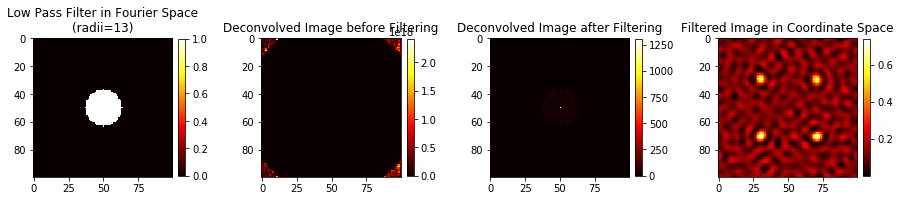

In [19]:
filtered_g2 = filter_image(G2, 13)

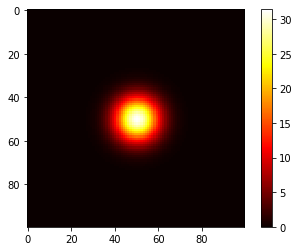

In [20]:
plt.imshow(np.abs(H), cmap='hot')
plt.colorbar()


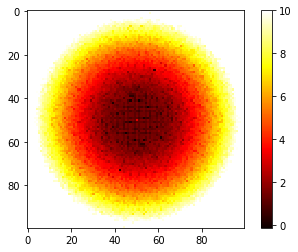

In [21]:
plt.imshow(np.log10(np.abs(G2/H)), cmap='hot', vmax=10)
plt.colorbar()

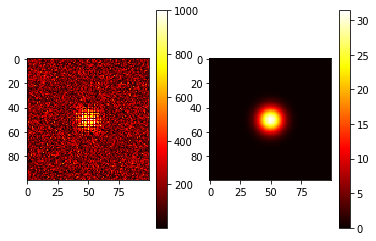

In [22]:
plt.subplot(1,2,1)
plt.imshow(np.abs(G2), cmap='hot', vmax=1000)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.abs(H), cmap='hot')
plt.colorbar()

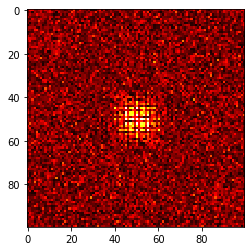

In [23]:

plt.imshow(np.abs(G2), cmap='hot', vmax=1000)

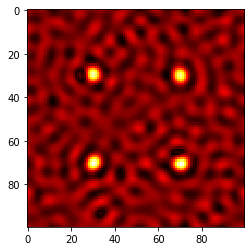

In [24]:
# now do the deconvolution
# why does it look nothing like the original image?
# g1 = np.fft.ifft2(np.fft.ifftshift(filtered_G2))
# try filtering after deconvolution
plt.imshow(filtered_g2, cmap='hot')

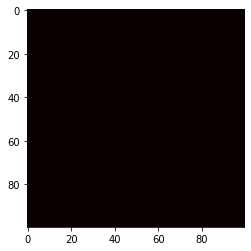

In [25]:
# try cutting off all the noise
height, width = filtered_g2.shape
for i in range(height):
    for j in range(width):
        if filtered_g2[i, j] < 10:
            filtered_g2[i, j] = 0
plt.imshow(filtered_g2, cmap='hot')

In [26]:
g1_binarized = np.fft.ifft2(np.fft.ifftshift(filtered_G2 / H))
plt.imshow(np.abs(g1_binarized), cmap='hot')


NameError: name 'filtered_G2' is not defined

4) Regularized Filter
-------------------
To suppress noise, use the regularized filter instead of the inverse filter, i.e.
$$G1 = \frac{H}{|H|^2 + \alpha |L|^2} G_2$$
where $\alpha$ is the Lagrange multiplier, $L$ is a high pass filter.
At higher frequencies, $H$ is very small, and this causes the noise to dominate. Instead, we add a high pass filter to the denominator so that at high frequencies the denominator remains large, thus suppressing the noise.

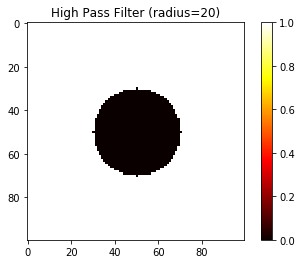

In [27]:
radius = 20
L = make_circ_mask((100, 100), radius)
L = -L + 1
plt.title(f"High Pass Filter (radius={radius})")
plt.imshow(L, cmap='hot')
plt.colorbar()



In [28]:
def regularized_filter(r, alpha):
    L = make_circ_mask((img_size, img_size), r)
    L = -L + 1
    plt.figure(figsize=(15,15))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    plt.subplot(131)
    plt.title(f"High Pass Filter (radius={radius})")
    plt.imshow(L, cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)


    G1 = H * G2 / (np.abs(H)**2 + alpha * (L*L))
    g1 = np.fft.fftshift(np.fft.ifft2(G1))
    plt.subplot(132)
    plt.title("Filtered Image")
    # print(H)
    plt.imshow(np.abs(g1), cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    plt.subplot(133)
    plt.title("Original Image")
    plt.imshow(g2, cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    plt.show()

height, width = g2.shape
interactive_plot = interactive(regularized_filter, r=(0, height//2), alpha=(0., 100))
output = interactive_plot.children[-1]
output.layout.height = '300px'
interactive_plot


interactive(children=(IntSlider(value=25, description='r', max=50), FloatSlider(value=50.0, description='alpha…

5) Richardson-Lucy Algorithm
----------------------
Here we implement the richardson-lucy algorithm

Definition: the RL algorithm is computed iteratively. Suppose that the image is generated through the process
$$g_2 = g_1 * h + n$$
where $g_1$, $h$, $n$ are all dependent on frequency. Then the RL algorithm is
$$g_1^{(r+1)} = g_1^{(r)} \left[h * \left(\frac{g_2}{g_1^{(r)}*h}\right)\right]$$

This is a none linear algorithm (quoted) (what does this mean?)

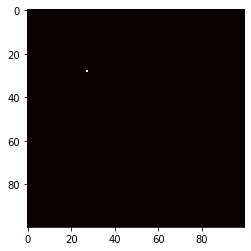

In [133]:
# why are there two lines in the top and the left???
output_rl = richardson_lucy_deconv(g2, h, 1000)
plt.imshow(output_rl, cmap='hot')

In [30]:
def rl(i):
    output_rl2 = richardson_lucy_deconv(g2, h, i)
    # plt.imshow(output_rl2, cmap='hot')
    return output_rl2
# interactive_plot = interactive(rl, i=(0, 10))
# output = interactive_plot.children[-1]
# output.layout.height = '300px'
# interactive_plot

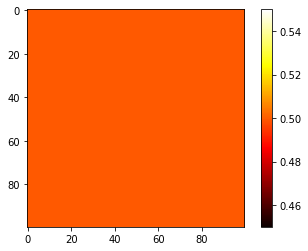

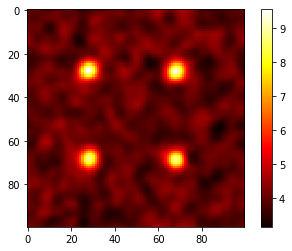

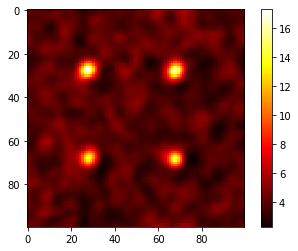

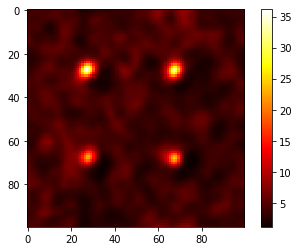

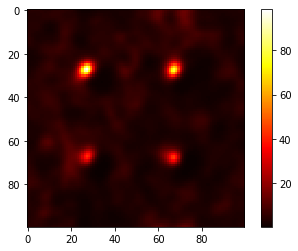

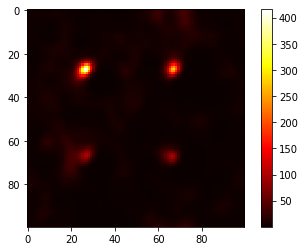

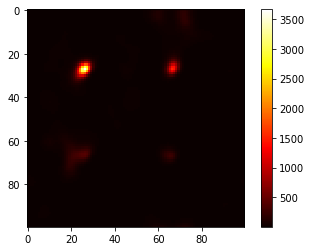

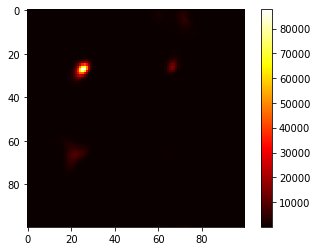

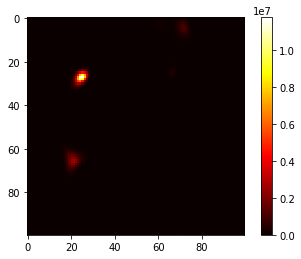

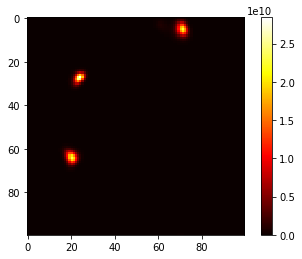

In [31]:
outputs_rl = []
for i in range(10):
    outputs_rl.append(rl(i))
    plt.imshow(outputs_rl[i], cmap='hot')
    plt.colorbar()
    plt.show()

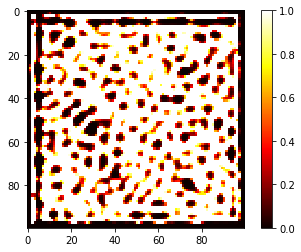

In [129]:
from skimage import color, data, restoration
deconvolved_RL = restoration.richardson_lucy(g2, h, iterations=250)

plt.imshow(deconvolved_RL, cmap='hot')
plt.colorbar()

In [113]:
deconvolved_RL

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.91155807]])

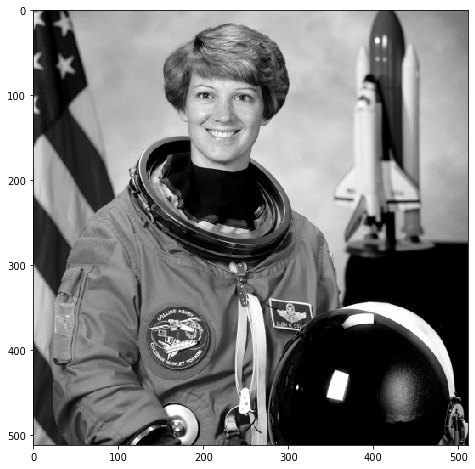

In [69]:

astro = color.rgb2gray(data.astronaut())
plt.figure(figsize=(8,8))
plt.imshow(astro, cmap='gray')


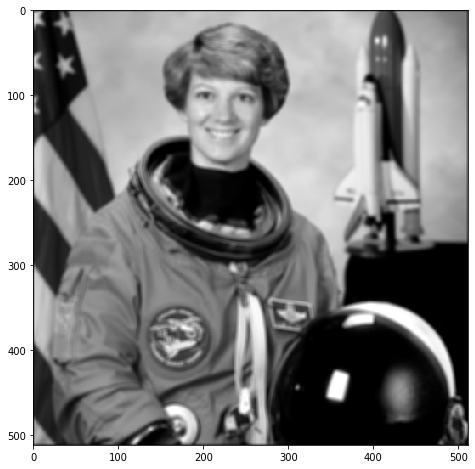

In [90]:
from scipy.signal import convolve2d
psf = np.ones((5, 5))/2
astro_blurred = convolve2d(astro, psf, 'same')
plt.figure(figsize=(8,8))
plt.imshow(astro_blurred, cmap='gray')

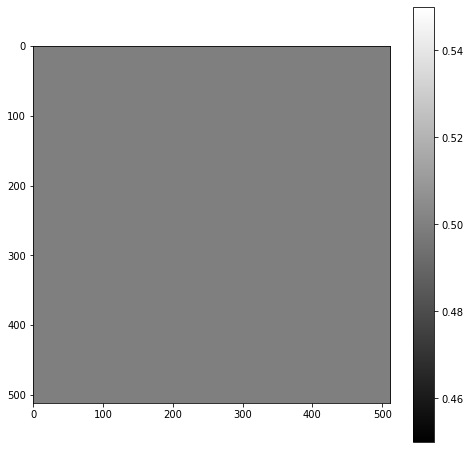

In [87]:
plt.figure(figsize=(8,8))
astro_restored = restoration.richardson_lucy(astro_blurred, psf, iterations=0)
plt.imshow(astro_restored, cmap='gray', vmax=np.max(astro_restored), vmin=np.min(astro_restored))
plt.colorbar()

In [86]:
astro_restored

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

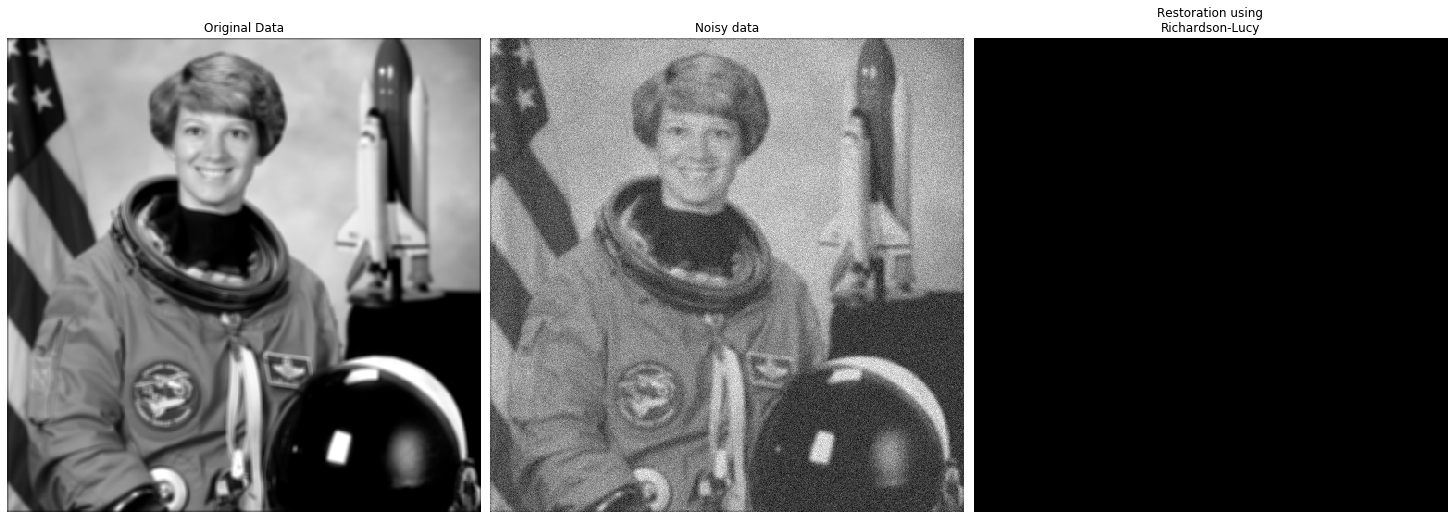

In [100]:
import matplotlib.pyplot as plt

from scipy.signal import convolve2d as conv2

from skimage import color, data, restoration

astro = color.rgb2gray(data.astronaut())

psf = np.ones((5, 5)) / 25
astro = conv2(astro, psf, 'same')
# Add Noise to Image
astro_noisy = astro.copy()
astro_noisy += (np.random.poisson(lam=500, size=astro.shape) - 10) / 255.

# Restore Image using Richardson-Lucy algorithm
deconvolved_RL = restoration.richardson_lucy(astro_noisy, psf, iterations=500)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
plt.gray()

for a in (ax[0], ax[1], ax[2]):
       a.axis('off')

ax[0].imshow(astro)
ax[0].set_title('Original Data')

ax[1].imshow(astro_noisy)
ax[1].set_title('Noisy data')

ax[2].imshow(deconvolved_RL, vmin=astro_noisy.min(), vmax=astro_noisy.max())
ax[2].set_title('Restoration using\nRichardson-Lucy')


fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.show()

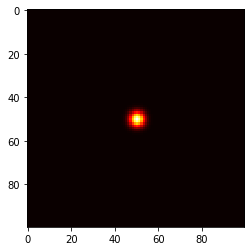

In [33]:
plt.imshow(h, cmap='hot')

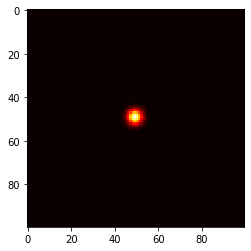

In [34]:
plt.imshow(h[::-1, ::-1], cmap='hot')

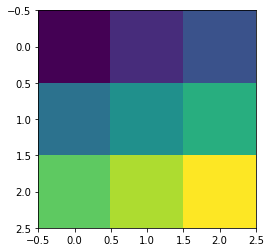

In [35]:
img_a = np.linspace(1, 9, 9).reshape((3, 3))
plt.imshow(img_a)

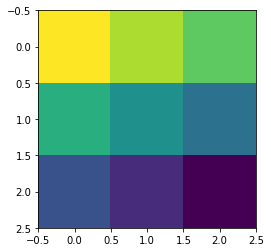

In [36]:
plt.imshow(img_a[::-1, ::-1])

6) Wiener Deconvolution
------------------
It is seen in section 4 that a regularized filter is suitable for filtering out high frequency noise. However, it is unsure what kind of high pass filter one should define to achieve optimal image quality. Wiener deconvolution is the optimal, it is defined as
$$F = \frac{H^* S}{|H|^2 S + V}$$
where $H$, $S$, $N$ are the OTF, the mean power spectral density of the original signal (i.e. $E[|G_1|^2]$), and $V$ is the mean power spectral density of the shot noise (i.e. $E[|N|^2]$, where $N$ is the Fourier transform of the noise)
To derive it, we assume that in Fourier space there is one function $F$ such that 
$$F\cdot G_2 = \hat{G_1}$$
Denote the predicted original image as $\hat{G_1}$, and the true original image as $G_1$, minimize the mean squared error
$$\epsilon = E[|\hat{G_1} - G_1|^2]$$
$$ = E[|FG_2 - G_1|^2]$$
$$= E[|F(G1\cdot H + N) - G_1|^2]$$
$$ = E[|(1-FH)G_1 - FN|^2]$$
The expression in the expectation brackets evaluates to 
$$ |1-FH|^2|G_1|^2 +|F|^2|N|^2 - F^* (1-FH) G_1N^* - F(1-F^* H^*) NG_1^*$$
Since $F$ and $H$ are constants, they can be taken out of the expectation bracket, and we end up with
$$ |1-FH|^2E[|G_1|^2] +|F|^2E[|N|^2] - F^* (1-FH) E[G_1N^*] - F(1-F^* H^*) E[NG_1^*]$$
Since the noise and the signal are uncorrelated, the last two terms are 0.
Therefore,
$$\epsilon = |1-FH|^2E[|G_1|^2] +|F|^2E[|N|^2]$$
Taking its derivative with respect to $F$,

$$\frac{d\epsilon}{dF} = F^* E[|N|^2] - H [1-F^*H^*] E[|G_1|^2] = 0$$
Let $S = E[|G_1|^2]$, $V = E[|N|^2]$,
rearranging the above equation, 
$$F^* = \frac{HS}{V+|H|^2S}$$
$$\Longrightarrow F = \frac{H^*S}{V + |H|^2 S}$$

One can gain intuition about the Wiener deconvolution by rearranging the formula intuition
$$F = \frac{1}{H} \frac{1}{1+\frac{1}{|H|^2\frac{S}{V}}}$$

$\frac{S}{V}$ is just the square of the signal to noise ratio in the Fourier space. As this goes to infinity, meaning that there is no noise, we can see that the Wiener deconvolution reduces to the standard inverse filter. As it goes to 1 or even smaller, the denominator becomes large, thus resembling the characteristics of a regularized filter. In some sense, we can interpret the Wiener deconvolution as an adaptive regularized filter for varying levels of signal to noise ratios.
\newline
In the coordinate space, noise is a poisson distribution with uniform lambda, so the expectation of it is a uniform distribution. In Fourier space, the expectation is the Fourier transform of the expectation value in coordinate space. 
As for the signal, the original object is a dot in coordinate space, when convoluted with h, it becomes a Gaussian. To find $S$, we want to calculate the expectation value of the square of a dot transformed into Fourier space. The question is what is the value of the dot?

Should the dot be modeled as a Dirac Delta? If so, then the amplitude of the dot will just be the value of the uniform distribution in the Fourier space.
After some experiments, it appears to be so.
So the expectation value of the dot in Fourier space is just a uniform distribution (actually, without taking np.abs, the complex numbers across the image will have the same amplitude but different phases)

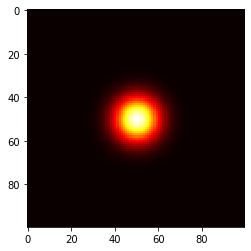

TypeError: Invalid shape () for image data

array([1.-9.j, 1.+9.j])

In [40]:
# dot intensity == gaussian peak itensity in coordinate space 

In [41]:
# calculate S = E[|G_1|^2]
# G1 is a uniform distribution with amplitude equaling to the photon_from_atom
# 

In [42]:
# calculate V = E[|N|^2]
# N is a Poisson process with mean lambda(which is always 1), so in the fourier space it is a delta function times lambda (1). But this is just 1. 
# No but V and S should be functions of frequency

In [43]:
print(g2)

[[4. 5. 7. ... 4. 8. 4.]
 [4. 3. 4. ... 3. 1. 1.]
 [2. 6. 6. ... 2. 6. 1.]
 ...
 [0. 5. 7. ... 1. 6. 4.]
 [2. 7. 3. ... 4. 4. 2.]
 [6. 3. 8. ... 4. 4. 4.]]


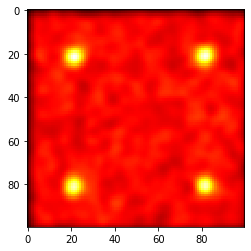

In [44]:
truth = convolve2d(g2, h, mode='same')
plt.imshow(truth, cmap='hot')

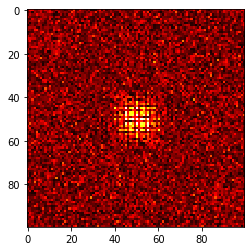

In [45]:
# a = np.fft.fftshift(np.fft.fft(g2))
a = np.fft.fft2(g2)
# visualize(np.abs(np.fft.fftshift(a)))
plt.imshow(np.abs(np.fft.fftshift(a)), cmap='hot', vmax=1000)

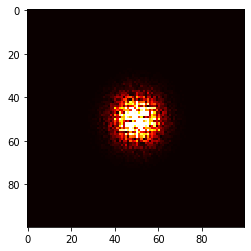

In [46]:
# product = np.fft.fftshift(np.fft.fft2(g2)) * np.fft.fftshift(np.fft.fft2(h))
product = np.fft.fftshift(np.fft.fft2(g2)) * np.fft.fftshift(np.fft.fft2(h))
plt.imshow(np.abs(product), cmap='hot', vmax=10000)


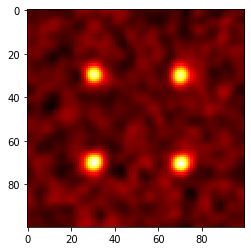

In [47]:
# result = np.abs(np.fft.ifft2(np.fft.fftshift(product)))
result = np.abs(np.fft.ifft2(np.fft.ifftshift(product)))
plt.imshow(result, cmap='hot')

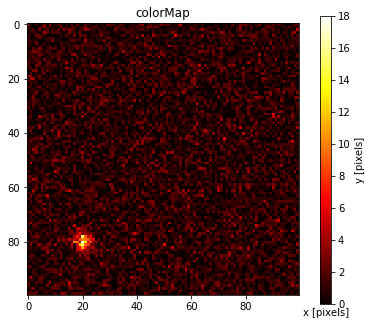

Instance info:
img_size: 100
exposure_time: 1
atom_variance: 5
quantum_efficiency: 1
atom count: 1
photons_in_background is set to 1 by default
SNR: 10
x0: 20
y0: 80


In [48]:
g3 = sim.create_simulation_from_SNR(x0[0], y0[0], 10, verbose=True)

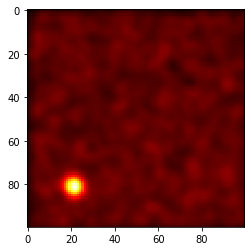

In [49]:
b = convolve2d(h, g3, mode='same')
plt.imshow(b, cmap='hot')

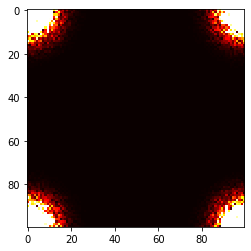

In [50]:
product2 = np.fft.fft2(g3[::-1, ::-1]) * np.fft.fft2(h)
plt.imshow(np.abs(product2), cmap='hot', vmax=1000)

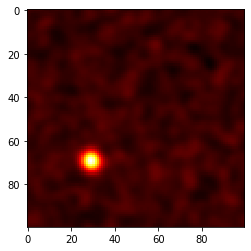

In [51]:
result2 = np.fft.ifft2(product2)
plt.imshow(np.abs(result2), cmap='hot')

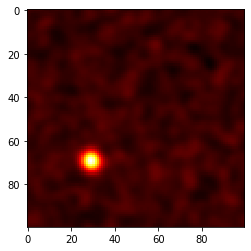

In [52]:
result_convolve = convolve(g3, h)
plt.imshow(result_convolve, cmap='hot')

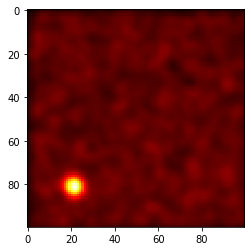

In [54]:
from scipy.signal import fftconvolve
result4 = fftconvolve(g3, h, mode='same')
plt.imshow(result4, cmap='hot')